# Imports e carregamentos

In [189]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [190]:
df = pd.read_csv('data_live_engineer.csv', encoding='utf-8')

# Analisando a importancia das ligas depois da engenharia de características

## Preprocessamento

In [191]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

# Verificar a presença de valores infinitos (as vezes existem divisões por zero)
print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# substituído pelo último valor não-NaN anterior na coluna.
df.fillna(method='ffill', inplace=True)

minute                           0
homeTeam                         0
awayTeam                         0
shotsHome                        0
shotsAway                        0
blockedShotsHome                 0
blockedShotsAway                 0
league                           0
corners_home                     0
corners_away                     0
shotsOffgoal_home                0
shotsOffgoal_away                0
shotsOngoal_home                 0
shotsOngoal_away                 0
fouls_home                       0
fouls_away                       0
tackles_home                     0
tackles_away                     0
result                           0
match_id                         0
possessiontime_away              0
possessiontime_home              0
total_cards                      0
aggressiveness_over_time_home    0
aggressiveness_over_time_away    0
defensive_efficiency_home        0
defensive_efficiency_away        0
possession_efficiency_home       0
possession_efficienc

## Treinando modelo de cada liga

In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

Treinando modelo para a liga: South America - Copa Libertadores
Média AUC para South America - Copa Libertadores: 0.9712159821025249
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       243
           1       0.93      0.89      0.91       174

    accuracy                           0.92       417
   macro avg       0.92      0.92      0.92       417
weighted avg       0.92      0.92      0.92       417


Treinando modelo para a liga: Asia - AFC Champions League
Média AUC para Asia - AFC Champions League: 0.9736182630106557
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       205
           1       0.90      0.89      0.89       129

    accuracy                           0.92       334
   macro avg       0.92      0.91      0.91       334
weighted avg       0.92      0.92      0.92       334


Treinando modelo para a liga: Brazil - Paulista A1
Média AUC para Brazil - Paulista A1: 0.

## Avaliando importancia das features de cada liga

In [ ]:
# # Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
# feature_names = X.columns

# # Loop para criar um gráfico para cada liga
# for league, data in league_histories.items():
#     # Ordenar as características e suas importâncias
#     sorted_idx = np.argsort(data['feature_importance'])
#     sorted_feature_names = feature_names[sorted_idx]
#     sorted_importances = data['feature_importance'][sorted_idx]

#     # Criando o gráfico
#     plt.figure(figsize=(10, 8))
#     plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
#     plt.title(f'Feature Importance for {league}')
#     plt.xlabel('Importance')
#     plt.ylabel('Features')
#     plt.show()


## Visualizando média e variância da importância das ligas

In [194]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
# dataframe_league.to_csv('dataframe_leagues_avaliation_before_f_engineering.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.971216,0.997751,0.972163,"[0.19221209252889904, 0.018903749985625107, 0...."
Asia - AFC Champions League,0.973618,0.998664,0.965097,"[0.19331492396738525, 0.022612162736109595, 0...."
Brazil - Paulista A1,0.970980,0.998709,0.966411,"[0.1721892491943729, 0.009324001241425404, 0.0..."
South America - Copa Sudamericana,0.977161,0.998789,0.993184,"[0.20163638954234964, 0.01887873722338758, 0.0..."
Japan - J-League,0.969980,0.996330,0.971926,"[0.2037265176039657, 0.01794810996686264, 0.01..."
USA - Major League Soccer,0.951852,0.991166,0.957076,"[0.16764988825586322, 0.018729859550974545, 0...."
Mexico - Liga MX,0.961231,0.996242,0.961237,"[0.1619573376425672, 0.021290641243352112, 0.0..."
Scotland - Premiership,0.972696,0.999169,0.963400,"[0.18625831112996946, 0.010011752971632041, 0...."
Brazil - Serie A,0.968297,0.994553,0.974436,"[0.1957431395802452, 0.012591308523661712, 0.0..."
France - Ligue 1,0.973763,0.998993,0.983845,"[0.16904906540844158, 0.019229168383304053, 0...."


In [195]:
# We calculate the mean importance for each feature across all leagues
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# First, let's convert the list of feature importances into a DataFrame for easier analysis
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculating the variance of each feature's importance across all leagues
feature_variances = df_feature_importances.var()

# Creating a summary DataFrame to hold the variance and correlation data
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Display the summary dataframe sorted by variance to see which features have the most variability across leagues
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
0,0,0.170901,0.000523,minute
1,18,0.074686,0.000279,aggressiveness_over_time_home
4,26,0.056861,0.000105,pressure_over_time_home
2,27,0.056131,0.000130,pressure_over_time_away
3,19,0.056093,0.000111,aggressiveness_over_time_away
5,30,0.055288,0.000078,possession_progress_home
6,31,0.051851,0.000055,possession_progress_away
15,36,0.029251,0.000018,game_momentum_home
10,37,0.028632,0.000028,game_momentum_away
8,38,0.024319,0.000045,total_fouls


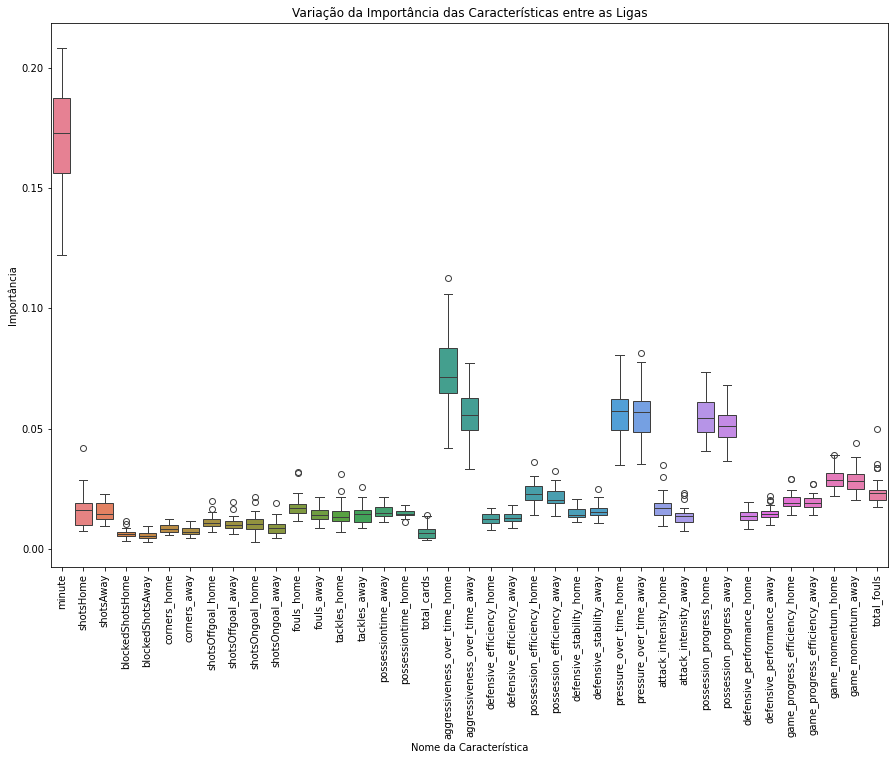

In [196]:
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

## Analisando características com baixa importancia

In [197]:
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
0,0,0.170901,0.000523,minute
1,18,0.074686,0.000279,aggressiveness_over_time_home
4,26,0.056861,0.000105,pressure_over_time_home
2,27,0.056131,0.000130,pressure_over_time_away
3,19,0.056093,0.000111,aggressiveness_over_time_away
5,30,0.055288,0.000078,possession_progress_home
6,31,0.051851,0.000055,possession_progress_away
15,36,0.029251,0.000018,game_momentum_home
10,37,0.028632,0.000028,game_momentum_away
8,38,0.024319,0.000045,total_fouls


In [198]:
summary_df.sort_values('Variance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
0,0,0.170901,0.000523,minute
1,18,0.074686,0.000279,aggressiveness_over_time_home
2,27,0.056131,0.000130,pressure_over_time_away
3,19,0.056093,0.000111,aggressiveness_over_time_away
4,26,0.056861,0.000105,pressure_over_time_home
5,30,0.055288,0.000078,possession_progress_home
6,31,0.051851,0.000055,possession_progress_away
7,1,0.016541,0.000053,shotsHome
8,38,0.024319,0.000045,total_fouls
9,28,0.017228,0.000028,attack_intensity_home


In [199]:
# summary_df.to_csv('summary_df.csv', index=False, encoding='utf-8')

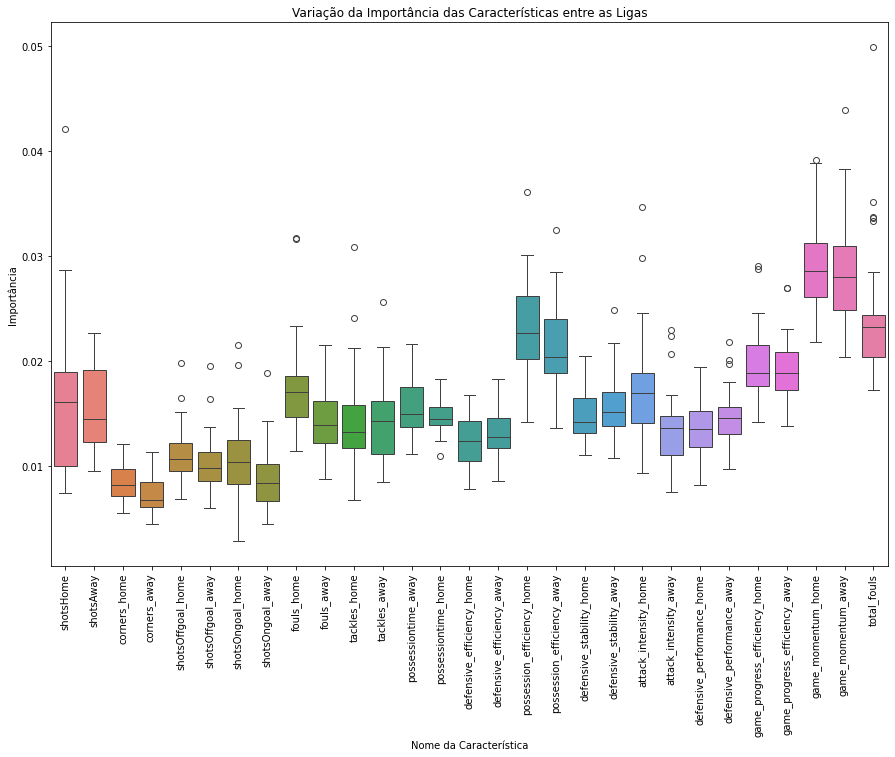

In [206]:
low_importance_features_indices1 = summary_df[summary_df['Mean Importance'] <= 0.007]['Feature'].tolist()
low_importance_features_indices2 = summary_df[summary_df['Variance'] >= 0.000054]['Feature'].tolist()
low_importance_features_indices = low_importance_features_indices1 + low_importance_features_indices2

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


In [207]:
# agora posso excluir características com baixa importância e alta variância
low_importance_features_mean = summary_df[summary_df['Mean Importance'] <= 0.007]['Feature Name'].tolist()
low_importance_features_var = summary_df[summary_df['Variance'] >= 0.000054]['Feature Name'].tolist()
low_importance_features = low_importance_features_mean + low_importance_features_var
print("Características com baixa importância:\n", low_importance_features)

Características com baixa importância:
 ['total_cards', 'blockedShotsHome', 'blockedShotsAway', 'minute', 'aggressiveness_over_time_home', 'pressure_over_time_away', 'aggressiveness_over_time_away', 'pressure_over_time_home', 'possession_progress_home', 'possession_progress_away']


- Características com Baixa Importância: As características que têm importância média muito baixa e variância alta podem ser excluídas, pois provavelmente não contribuirão significativamente para o modelo ou podem introduzir ruído. 

In [208]:
df = pd.read_csv('data_live_engineer.csv', encoding='utf-8')
df.drop(low_importance_features, axis=1, inplace=True)
df.to_csv("data_live_engineer_filtered.csv", index=False, encoding="utf-8")

In [209]:
df.columns

Index(['homeTeam', 'awayTeam', 'shotsHome', 'shotsAway', 'league',
       'corners_home', 'corners_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'fouls_home', 'fouls_away', 'tackles_home', 'tackles_away', 'result',
       'match_id', 'possessiontime_away', 'possessiontime_home',
       'defensive_efficiency_home', 'defensive_efficiency_away',
       'possession_efficiency_home', 'possession_efficiency_away',
       'defensive_stability_home', 'defensive_stability_away',
       'attack_intensity_home', 'attack_intensity_away',
       'defensive_performance_home', 'defensive_performance_away',
       'game_progress_efficiency_home', 'game_progress_efficiency_away',
       'game_momentum_home', 'game_momentum_away', 'total_fouls'],
      dtype='object')

## Preprocessamento

In [210]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

# Preparando os dados de entrada e saída
X = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
y = df['result']

preprocessor = create_preprocessor(X)
X_transformed = preprocessor.transform(X)

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor_league.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor_league.pickle'.")

# Verificar a presença de valores infinitos (as vezes existem divisões por zero)
# print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# # Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # substituído pelo último valor não-NaN anterior na coluna.
# df.fillna(method='ffill', inplace=True)

Preprocessador salvo em '../models/preprocessor_league.pickle'.


## Treinando modelo de cada liga

In [211]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

    # salvando o modelo
    filename = f'../models/model_randomf_{league}.sav'
    pickle.dump(model_randomf, open(filename, 'wb'))


Treinando modelo para a liga: South America - Copa Libertadores
Média AUC para South America - Copa Libertadores: 0.952395439162147
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       243
           1       0.87      0.93      0.89       174

    accuracy                           0.91       417
   macro avg       0.90      0.91      0.91       417
weighted avg       0.91      0.91      0.91       417


Treinando modelo para a liga: Asia - AFC Champions League
Média AUC para Asia - AFC Champions League: 0.950979649528248
              precision    recall  f1-score   support

           0       0.96      0.86      0.90       205
           1       0.81      0.94      0.87       129

    accuracy                           0.89       334
   macro avg       0.88      0.90      0.89       334
weighted avg       0.90      0.89      0.89       334


Treinando modelo para a liga: Brazil - Paulista A1
Média AUC para Brazil - Paulista A1: 0.95

In [212]:
# Treinando modelo para a liga: Brazil - Paulista A1
# Média AUC para Brazil - Paulista A1: 0.9294938532263481
#               precision    recall  f1-score   support

#            0       0.92      0.82      0.87       317
#            1       0.82      0.92      0.87       283

#     accuracy                           0.87       600
#    macro avg       0.87      0.87      0.87       600
# weighted avg       0.87      0.87      0.87       600


# Treinando modelo para a liga: Asia - AFC Champions League
# Média AUC para Asia - AFC Champions League: 0.9416701601248073
#               precision    recall  f1-score   support

#            0       0.94      0.85      0.90       246
#            1       0.86      0.94      0.90       236

#     accuracy                           0.90       482
#    macro avg       0.90      0.90      0.90       482
# weighted avg       0.90      0.90      0.90       482


# Treinando modelo para a liga: South America - Copa Libertadores
# Média AUC para South America - Copa Libertadores: 0.9246692558721168
#               precision    recall  f1-score   support

#            0       0.91      0.85      0.88       413
#            1       0.84      0.91      0.88       370

#     accuracy                           0.88       783
#    macro avg       0.88      0.88      0.88       783
# weighted avg       0.88      0.88      0.88       783


# Treinando modelo para a liga: South America - Copa Sudamericana
# Média AUC para South America - Copa Sudamericana: 0.936965631303714
#               precision    recall  f1-score   support

#            0       0.92      0.85      0.88       293
#            1       0.84      0.91      0.87       247

#     accuracy                           0.88       540
#    macro avg       0.88      0.88      0.88       540
# weighted avg       0.88      0.88      0.88       540


# Treinando modelo para a liga: USA - Major League Soccer
# Média AUC para USA - Major League Soccer: 0.8888188532579495
#               precision    recall  f1-score   support

#            0       0.87      0.78      0.82       842
#            1       0.79      0.87      0.83       800

#     accuracy                           0.82      1642
#    macro avg       0.83      0.83      0.82      1642
# weighted avg       0.83      0.82      0.82      1642


# Treinando modelo para a liga: Mexico - Liga MX
# Média AUC para Mexico - Liga MX: 0.9222377536648521
#               precision    recall  f1-score   support

#            0       0.90      0.83      0.87       446
#            1       0.83      0.90      0.86       396

#     accuracy                           0.86       842
#    macro avg       0.87      0.87      0.86       842
# weighted avg       0.87      0.86      0.86       842


# Treinando modelo para a liga: Brazil - Serie A
# Média AUC para Brazil - Serie A: 0.9085925821134178
#               precision    recall  f1-score   support

#            0       0.88      0.81      0.85       675
#            1       0.81      0.88      0.84       607

#     accuracy                           0.84      1282
#    macro avg       0.84      0.85      0.84      1282
# weighted avg       0.85      0.84      0.84      1282


# Treinando modelo para a liga: France - Ligue 1
# Média AUC para France - Ligue 1: 0.9256672120474165
#               precision    recall  f1-score   support

#            0       0.97      0.82      0.89       377
#            1       0.81      0.96      0.88       302

#     accuracy                           0.88       679
#    macro avg       0.89      0.89      0.88       679
# weighted avg       0.90      0.88      0.88       679


# Treinando modelo para a liga: England - Carabao Cup
# Média AUC para England - Carabao Cup: 0.9248254475284069
#               precision    recall  f1-score   support

#            0       0.92      0.85      0.89       206
#            1       0.86      0.92      0.89       196

#     accuracy                           0.89       402
#    macro avg       0.89      0.89      0.89       402
# weighted avg       0.89      0.89      0.89       402


# Treinando modelo para a liga: England - Premier League
# Média AUC para England - Premier League: 0.9257220010053885
#               precision    recall  f1-score   support

#            0       0.93      0.82      0.87       341
#            1       0.82      0.93      0.87       291

#     accuracy                           0.87       632
#    macro avg       0.87      0.88      0.87       632
# weighted avg       0.88      0.87      0.87       632


# Treinando modelo para a liga: Spain - La Liga
# Média AUC para Spain - La Liga: 0.9339203418658355
#               precision    recall  f1-score   support

#            0       0.92      0.85      0.89       384
#            1       0.84      0.91      0.87       316

#     accuracy                           0.88       700
#    macro avg       0.88      0.88      0.88       700
# weighted avg       0.88      0.88      0.88       700


# Treinando modelo para a liga: England - League Two
# Média AUC para England - League Two: 0.9162253080736044
#               precision    recall  f1-score   support

#            0       0.92      0.77      0.84       464
#            1       0.78      0.92      0.84       411

#     accuracy                           0.84       875
#    macro avg       0.85      0.84      0.84       875
# weighted avg       0.85      0.84      0.84       875


# Treinando modelo para a liga: Europe - Europa League
# Média AUC para Europe - Europa League: 0.9193146811327566
#               precision    recall  f1-score   support

#            0       0.95      0.85      0.90       360
#            1       0.84      0.94      0.89       293

#     accuracy                           0.89       653
#    macro avg       0.89      0.90      0.89       653
# weighted avg       0.90      0.89      0.89       653


# Treinando modelo para a liga: Italy - Serie A
# Média AUC para Italy - Serie A: 0.9253740265567082
#               precision    recall  f1-score   support

#            0       0.91      0.81      0.86       315
#            1       0.82      0.92      0.87       297

#     accuracy                           0.86       612
#    macro avg       0.87      0.87      0.86       612
# weighted avg       0.87      0.86      0.86       612


# Treinando modelo para a liga: Europe - Champions League
# Média AUC para Europe - Champions League: 0.9319994636155491
#               precision    recall  f1-score   support

#            0       0.95      0.83      0.88       291
#            1       0.83      0.95      0.89       263

#     accuracy                           0.88       554
#    macro avg       0.89      0.89      0.88       554
# weighted avg       0.89      0.88      0.88       554


# Treinando modelo para a liga: Argentina - Superliga
# Média AUC para Argentina - Superliga: 0.9182995242589385
#               precision    recall  f1-score   support

#            0       0.86      0.83      0.84       552
#            1       0.83      0.85      0.84       517

#     accuracy                           0.84      1069
#    macro avg       0.84      0.84      0.84      1069
# weighted avg       0.84      0.84      0.84      1069


# Treinando modelo para a liga: England - League One
# Média AUC para England - League One: 0.9208488177254243
#               precision    recall  f1-score   support

#            0       0.90      0.82      0.85       481
#            1       0.82      0.90      0.86       454

#     accuracy                           0.86       935
#    macro avg       0.86      0.86      0.86       935
# weighted avg       0.86      0.86      0.86       935


# Treinando modelo para a liga: Europe - UEFA Nations League
# Média AUC para Europe - UEFA Nations League: 0.9247891658005202
#               precision    recall  f1-score   support

#            0       0.93      0.82      0.87       395
#            1       0.82      0.93      0.87       345

#     accuracy                           0.87       740
#    macro avg       0.87      0.87      0.87       740
# weighted avg       0.88      0.87      0.87       740


# Treinando modelo para a liga: Greece - Super League
# Média AUC para Greece - Super League: 0.9453391163928059
#               precision    recall  f1-score   support

#            0       0.97      0.83      0.90       200
#            1       0.85      0.97      0.91       187

#     accuracy                           0.90       387
#    macro avg       0.91      0.90      0.90       387
# weighted avg       0.91      0.90      0.90       387


# Treinando modelo para a liga: Japan - J-League
# Média AUC para Japan - J-League: 0.9104849983415033
#               precision    recall  f1-score   support

#            0       0.90      0.84      0.87       538
#            1       0.84      0.90      0.87       501

#     accuracy                           0.87      1039
#    macro avg       0.87      0.87      0.87      1039
# weighted avg       0.87      0.87      0.87      1039


# Treinando modelo para a liga: England - Championship
# Média AUC para England - Championship: 0.9124886952772601
#               precision    recall  f1-score   support

#            0       0.91      0.81      0.86       539
#            1       0.82      0.92      0.87       503

#     accuracy                           0.86      1042
#    macro avg       0.87      0.86      0.86      1042
# weighted avg       0.87      0.86      0.86      1042


# Treinando modelo para a liga: Netherlands - Eredivisie
# Média AUC para Netherlands - Eredivisie: 0.9263778532432351
#               precision    recall  f1-score   support

#            0       0.92      0.88      0.90       209
#            1       0.89      0.93      0.91       217

#     accuracy                           0.90       426
#    macro avg       0.90      0.90      0.90       426
# weighted avg       0.90      0.90      0.90       426


# Treinando modelo para a liga: Portugal - Liga Portugal
# Média AUC para Portugal - Liga Portugal: 0.93293312838804
#               precision    recall  f1-score   support

#            0       0.88      0.87      0.88       237
#            1       0.88      0.89      0.88       237

#     accuracy                           0.88       474
#    macro avg       0.88      0.88      0.88       474
# weighted avg       0.88      0.88      0.88       474


# Treinando modelo para a liga: Italy - Serie B
# Média AUC para Italy - Serie B: 0.924182093196477
#               precision    recall  f1-score   support

#            0       0.93      0.82      0.87       272
#            1       0.82      0.93      0.87       246

#     accuracy                           0.87       518
#    macro avg       0.88      0.88      0.87       518
# weighted avg       0.88      0.87      0.87       518


# Treinando modelo para a liga: Spain - La Liga 2
# Média AUC para Spain - La Liga 2: 0.9332300250174475
#               precision    recall  f1-score   support

#            0       0.91      0.87      0.89       456
#            1       0.85      0.90      0.88       387

#     accuracy                           0.88       843
#    macro avg       0.88      0.88      0.88       843
# weighted avg       0.88      0.88      0.88       843


# Treinando modelo para a liga: Saudi Arabia - Pro League
# Média AUC para Saudi Arabia - Pro League: 0.9255631726480434
#               precision    recall  f1-score   support

#            0       0.92      0.83      0.87       284
#            1       0.84      0.92      0.88       273

#     accuracy                           0.87       557
#    macro avg       0.88      0.88      0.87       557
# weighted avg       0.88      0.87      0.87       557